In [1]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
#from scipy.stats import norm

from numpy.linalg import det, norm


from mpl_toolkits import mplot3d

import subprocess as sb
from subprocess import Popen, PIPE
import shlex

import time
import random

from datetime import datetime

from numpy import asarray
from numpy import savez_compressed

from scipy.stats import multivariate_normal
#%matplotlib inline

In [2]:
data_mat = scipy.io.loadmat('Data.mat')


In [3]:
test = np.array(data_mat['X'])
print(test.shape)

(5, 9999)


## Helper Functions

Below I have defined some helper functions to be used by the EM algorithm. Additionally I was having some issues using scipy normal distribution for random vectors so I just implemented my own using a function.




### Initiliazation of Parameters

To initialize the parameters, I randomly assigned each data point to a particular cluster index. The `update_parameters` function takes as input a responsibilities matrix of size |N|x|D| where N is the set of data-points and D is the dimensionality of each data-point and returns the updated parameters based on MLE estimation. I leverage this function to initialize the parameters by constructing a responsibility matrix with a 1.0 at the assigned label.  

### Convergance Function

The Expectation-Maximization Algorithm takes as input a function to run an arbritrary distortion function. I have currently implemented and use the L2 norm squared we discussed in class. Any other distortion can be utilized and the function definition has been kept generic by taking all parameters as input. At each iteration, the cost is returned and stored in the *prev_cost* variable. The check for convergance checks whether the cost of this iteration is >= previous iteration cost. It would exit when this condition is false.


### Problem Break-Down
I have broken the problem into 3 high level functions:

*1)* Initializing the parameters in `initialize_parameters`<br/>
*2)* Computing the responsibilities according to current parameter state in `compute_responsibilities`<br/>
*3)* Updating the parameters once we have responsibilities in `update_parameters`

Each function is explained in detail above its definition


In [4]:



"""
This function takes assigns random labels to data-points and creates
a responsibility matrix according to these labels (1 hot). It then invokes
the update_parameters method which returns the pi_s, mu_s, sigma_s, and 
responsibility matrix.
"""
def initialize_parameters(num_clusters, len_vector, x_s):
    np.random.seed(int(time.time()))
    labels = np.random.randint(0,num_clusters,x_s.shape[1])
 
    initial_resp = np.zeros((x_s.shape[1],num_clusters))
    
    for i in range(x_s.shape[1]):        
        # One hot encoding for initial responsibility
        initial_resp[i,labels[i]] = 1.0
    
    return update_parameters(initial_resp,x_s, num_clusters)

    
    

#. Calculate pi_k' * N(x|mu_k',sigma_k') over all k's once
def compute_weighted_product(pi_s,mu_s, sigma_s,x):
    products = []
    for k in range(0,len(pi_s)):
        norm_k_pdf = multivariate_normal(mean= mu_s[k,:].reshape(mu_s[k,:].shape[1],)
                                         , cov =sigma_s[k,:,:])
        pi_k = pi_s[k]

        product = np.array(pi_k*norm_k_pdf.pdf(x))
        products.append(product)
    
    return np.array(products)
        

    
"""
Given we have D datapoints each of length N and we have k clusters,
this returns a responsibilty matrix of size N * k

where indices [i,j] represent the responsibility for data point i
taken by cluster index k
"""
def compute_responsibilites(pi_s,mu_s,sigma_s,x_s):
    responsibilites = []
    log_liklihood = 0.0
    for i in range(0,x_s.shape[1]): #. For each data point
        responsibility = []
        products = compute_weighted_product(pi_s,mu_s,sigma_s,x_s[:,i])
        for k in range(0,len(pi_s)): #.  For each cluster index
            resp_term = products[k]/np.sum(products)
            responsibility.append(resp_term)
        log_liklihood += np.log(np.sum(products))
        responsibilites.append(responsibility)
    return np.array(responsibilites), log_liklihood
            

"""
Once we have responsibilities we can update the parameters according to
the MLE estimates.
"""
def update_parameters(resp_matrix, x_s,num_clusters):
    cluster_to_pi = {}
    cluster_to_mu = {}
    cluster_to_sigma = {}
    for i in range(0,resp_matrix.shape[0]):
        for k in range(0,num_clusters):
            
            if k not in cluster_to_pi:

                cluster_to_pi[k] = 0.0
            
            if k not in cluster_to_mu:
                cluster_to_mu[k] = np.zeros((1,x_s.shape[0]))
                #print(cluster_to_mu[k])
            
            if k not in cluster_to_sigma:
                cluster_to_sigma[k] = np.zeros((x_s.shape[0],x_s.shape[0]))
                
            cluster_to_pi[k] += resp_matrix[i,k]
            cluster_to_mu[k] += ((x_s[:,i]).T *resp_matrix[i,k])
                
    
    updated_pi_s = []
    updated_mu_s = []
    updated_sigma_s = []
    
    
    for k in range(0,num_clusters):
        
        cluster_to_pi[k] = cluster_to_pi[k] / resp_matrix.shape[0]
        cluster_to_mu[k] = cluster_to_mu[k] / np.sum(resp_matrix[:,k])
        
        
        
        for i in range(0,resp_matrix.shape[0]):
            
            delta_term = resp_matrix[i,k] * np.dot((x_s[:,i] - cluster_to_mu[k]).T,
                                                   (x_s[:,i] - cluster_to_mu[k]))
            
            cluster_to_sigma[k] += delta_term
        
        cluster_to_sigma[k] = cluster_to_sigma[k] / np.sum(resp_matrix[:,k])
        
        updated_pi_s.append(cluster_to_pi[k])
        updated_mu_s.append(cluster_to_mu[k])
        updated_sigma_s.append(cluster_to_sigma[k])
        
    
    
    return np.array(updated_pi_s), np.array(updated_mu_s), np.array(updated_sigma_s), resp_matrix
    
    
            

# Putting it all together

Now that we have all our helper functions we can simply combine them in our Algorithm according to our definition in class.

In [5]:
"""
    ================================================================
Expecation Max takes as arguments:
    
    num_clusters:  
        Number of clusters to partition the data in.
    
    x_s:
        The data points to cluster
        
    convergance:
        A function which returns a scalar distortion factor which can be used to end the loop
    
    
    ================================================================
    
    returns:
        an array indicating the cluster indices for each data point
    

"""
def pprint(msg):
    print("*"*10,msg,"*"*10)


def expectation_max(num_clusters,x_s, convergance):
    pprint("Invoked Expecation Maximization with {} clusters".format(num_clusters))
    
    
    #. Give inital values to paramters
    pi_s, mu_s, sigma_s, initial_resp = initialize_parameters(num_clusters, x_s.shape[0], x_s)
    
    is_converged = False
    
    prev_cost = convergance(pi_s,mu_s,sigma_s,x_s,initial_resp)
    
    prev_liklihood = 0.0
    
    #. To get initial log_liklihood for plotting
    r_, log_liklihood = compute_responsibilites(pi_s,mu_s,sigma_s,x_s)

    
    #. One of the return types of this function: Contains iteration statistics
    stats = {
        "iter":0,
        "distortion":[(0,prev_cost)],
        "liklihood": [(0,log_liklihood)],
    }
    
    #. A dictionary of parameters which is returned
    parameters = {
        "mu_s":mu_s,
        "pi_s":pi_s,
        "sigma_s":sigma_s
    }
    
    prev_resp = initial_resp
    
    while True:
        stats['iter'] += 1
        
        #print("Iteration:\t",stats['iter'])#,'Prev_Cost:\t',prev_cost)
        resp_matrix, log_liklihood = compute_responsibilites(pi_s,mu_s,sigma_s,x_s)
        
        
        
        pi_s, mu_s, sigma_s, _r = update_parameters(resp_matrix,x_s,num_clusters)
        
        cost = convergance(pi_s,mu_s,sigma_s,x_s,resp_matrix)
        
        
        
        
        is_converged = (cost >= prev_cost)
        
        if is_converged:
            break
        
        parameters = {
            "mu_s":mu_s,
            "pi_s":pi_s,
            "sigma_s":sigma_s
        }
        
        stats['liklihood'].append((stats['iter'],log_liklihood))
            
        prev_cost = cost
        prev_resp = resp_matrix
        prev_liklihood = log_liklihood
        
        stats['distortion'].append((stats['iter'],cost))
        
        
    pprint("Expectation Maximization Completed!")
    return get_labels(prev_resp), stats, parameters
 
def get_labels(resp_matrix):
    labels = []
    
    for i in range(0,resp_matrix.shape[0]):
        labels.append(np.argmax(resp_matrix[i,:]))
    
    return np.array(labels)
    

def l2_convergance(pi_s,mu_s,sigma_s,x_s,resp_matrix):
    
    cost = 0.0
    
    labels = get_labels(resp_matrix)
    
    for i in range(0,x_s.shape[1]):
        cost += np.power(norm(x_s[:,i] - mu_s[labels[i],:]),2)
    return cost
        
        

In [6]:
#. Note this can take some time, if you want to measure progress uncommend the 
#. print() in expectation which prints iteration numbers

classification,stats, params = expectation_max(6,test, l2_convergance)

********** Invoked Expecation Maximization with 6 clusters **********
********** Expectation Maximization Completed! **********


In [7]:

def inline_plot(classification,test):
    random.seed(datetime.now())

    colors = [(random.random(), random.random(), random.random()) for i in range(0,max(classification)+1)]#['red','blue','green','yellow','black','white',]

    plt_colors = [colors[i] for i in classification]

    fig = plt.figure()

    ax = plt.axes(projection='3d')
    ax.scatter3D(test[0,:],test[1,:],test[2,:],c=plt_colors)
    plt.show()


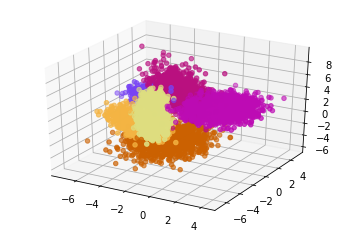

In [8]:
inline_plot(classification,test)

#### To view an interactive version of the plot, please check README.txt

In [9]:
# uncomment to save weights
#savez_compressed('classification.npz', classification)


In [10]:
def plot_stats(k,stats):
    plt.subplot(3, 1, 1)
    plt.plot([left for (left,right) in stats['distortion']],[right for (left,right) in stats['distortion']]
            ,'r-o')
    plt.title("Distortion vs Iteration for {} clusters".format(k))
    plt.xlabel("Iteration Number")
    plt.ylabel("L2 distortion")
    
    
    plt.subplot(3, 1, 3)
    plt.plot([left for (left,right) in stats['liklihood']],[right for (left,right) in stats['liklihood']]
            ,'b-o')
    plt.title("Log Liklihood vs Iteration for {} clusters".format(k))
    plt.xlabel("Iteration Number")
    plt.ylabel("Log-Liklihood")
    
    plt.show()

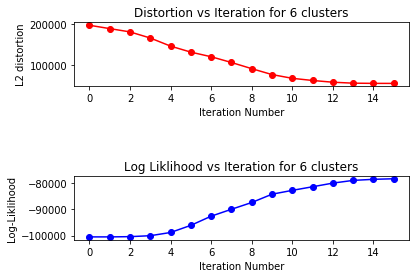

In [11]:
plot_stats(6,stats)

In [12]:
print(params)

{'mu_s': array([[[-1.91204231,  0.42554023,  3.83299541, -1.56868307,
          1.82031752]],

       [[-4.16845214,  1.0566305 ,  1.83390373, -0.27272126,
         -1.82748731]],

       [[-2.25397183, -3.31800807,  2.62415129,  2.32138781,
          1.96526615]],

       [[-1.64978279, -2.04463644, -2.25959921,  0.17027088,
          1.49360693]],

       [[-3.36886633, -3.39649795,  0.87069317, -2.01210173,
          1.76117766]],

       [[ 0.64573733,  1.41706955,  1.73043129, -1.42160104,
          1.07222091]]]), 'pi_s': array([0.09556945, 0.14794653, 0.28222322, 0.12687976, 0.09739776,
       0.24998327]), 'sigma_s': array([[[ 1.6423614 , -0.32789562, -0.84925489,  0.61769881,
         -0.5221513 ],
        [-0.32789562,  0.78265496,  0.18919512, -0.07665604,
         -0.01683635],
        [-0.84925489,  0.18919512,  2.51196324, -0.1233739 ,
         -0.31031439],
        [ 0.61769881, -0.07665604, -0.1233739 ,  0.80205704,
         -0.47146518],
        [-0.5221513 , -0.016836

## Comparing with provided Answers

In [14]:

data_test_mat = scipy.io.loadmat('Datatest.mat')
print(data_test_mat.keys())

print(np.sort(data_test_mat['pi']))
print(np.sort(params['pi_s']))

dict_keys(['__header__', '__version__', '__globals__', 'Sk', 'mu', 'pi', 'X'])
[[0.01043281 0.06744033 0.13592397 0.2366198  0.26895835 0.28062474]]
[0.09556945 0.09739776 0.12687976 0.14794653 0.24998327 0.28222322]


# DataKunknown  Processing

To obtain a good estimate of K on this data set, I will run K means from 1 to some arbritary value and store the resultant state in a dictionary. I would then plot the minimal distortion against k and see at which points does it begin to become constant or forms a bend (elbow). By inspection we can decide that point to be the number of clusters to use.

In [15]:
data_Kunknown_mat = scipy.io.loadmat('DataKunknown.mat')
#print(data_Kunknown_mat.keys())

unknown_data = np.array(data_Kunknown_mat['X'])
#print(unknown_data.shape)

### Finding the Best Cluster index

Below I run the EM algorithm from LOW to HIGH (both inclusive) cluster numbers and store the state in a dictionary. At each iteration, it also plots the respective distortion vs iteration plots for each number of clusters. In the following cell, I then extract out the minimal distortion value for each of the number of clusters and plot that.

In [37]:


LOW_LIM = 1
HIGH_LIM = 8

def show_best_cluster(data,LOW,HIGH):
    k_to_state_ = {}


    for k in range(LOW,HIGH+1):
        classification,stats, params = expectation_max(k,data, l2_convergance)
    
        plot_stats(k,stats)
        print("pi_s:\t",params['pi_s'])
    
        k_state = {
            "labels":classification,
            "stats":stats,
            "params":params
        }
        k_to_state_[k] = k_state
    return k_to_state_
        
def plot_best_cluster(k_to_state_,LOW,HIGH):
    X = list(range(LOW,HIGH+1))
    #print(X)
    Y_1 = []
    Y_2 = []

    prev_dist = 0.0
    for idx,x in enumerate(X):
        Y_1.append(k_to_state_[x]['stats']['distortion'][-1][1])
        Y_2.append(k_to_state_[x]['stats']['liklihood'][-1][1])
        
        
        
   
            
            
 
            

    plt.subplot(3, 1, 1)
    plt.plot(X,Y_1,'r-o')
    plt.title("Least Distortion vs Number of Clusters")
    plt.ylabel("Distortion")
    plt.xlabel("Number of Clusters, k")
    
    
    plt.subplot(3, 1, 3)
    plt.plot(X,Y_2,'b-o')
    plt.title("Highest Log Liklihood vs Number of Clusters")
    plt.ylabel("Log Liklihood")
    plt.xlabel("Number of Clusters, k")
    plt.show()
    
    for idx,x in enumerate(X):
        if idx != 0:
            cur_dist = k_to_state_[x]['stats']['distortion'][-1][1]
            
            # If decrease in distortion is less than 3 % we are stable
            if (-(cur_dist-prev_dist) / prev_dist) * 100.0   < 3.0:
                print("Ideal Cluster Number: ",x-1)
                print(k_to_state_[x-1]['params'])
                return (x-1)
            prev_dist = cur_dist
        else:
            prev_dist = k_to_state_[x]['stats']['distortion'][-1][1]
        
    
    print("Ideal Cluster Number: ",X[-1])
    print(k_to_state_[X[-1]]['params'])
    return X[-1]

    
    

### Plotting across number of Clusters
As we can see in the plot below, at number of clusters = 3, we achieve the bend. After that the distortion becomes more or less constant. Hence We can just choose $k^* = 3$. I save the appropriate data-point labeling and produce an inline plot of the coloring. (*below cell is scrollable*)

********** Invoked Expecation Maximization with 1 clusters **********
********** Expectation Maximization Completed! **********


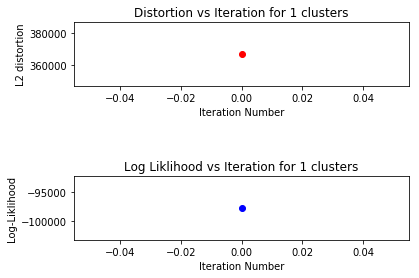

pi_s:	 [1.]
********** Invoked Expecation Maximization with 2 clusters **********
********** Expectation Maximization Completed! **********


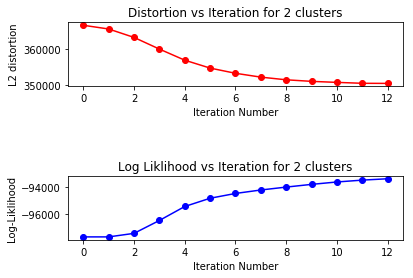

pi_s:	 [0.17887087 0.82112913]
********** Invoked Expecation Maximization with 3 clusters **********
********** Expectation Maximization Completed! **********


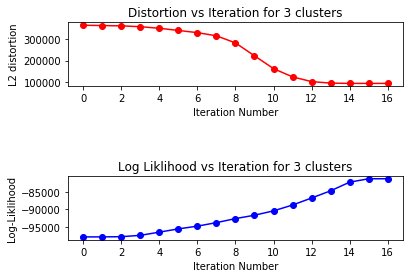

pi_s:	 [0.30176412 0.53027306 0.16796281]
********** Invoked Expecation Maximization with 4 clusters **********
********** Expectation Maximization Completed! **********


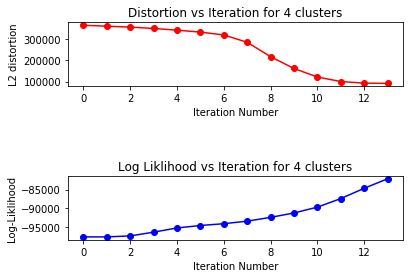

pi_s:	 [0.30262578 0.18585646 0.16059921 0.35091855]
********** Invoked Expecation Maximization with 5 clusters **********
********** Expectation Maximization Completed! **********


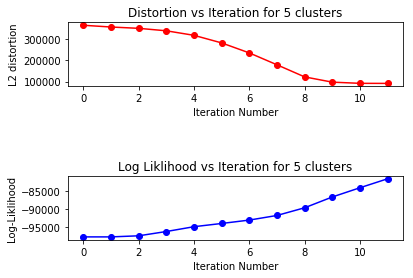

pi_s:	 [0.19761986 0.30140374 0.04032517 0.29772116 0.16293006]
********** Invoked Expecation Maximization with 6 clusters **********
********** Expectation Maximization Completed! **********


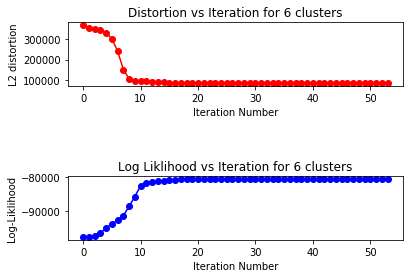

pi_s:	 [0.13278932 0.05358568 0.03824271 0.29834776 0.00356512 0.47346941]
********** Invoked Expecation Maximization with 7 clusters **********
********** Expectation Maximization Completed! **********


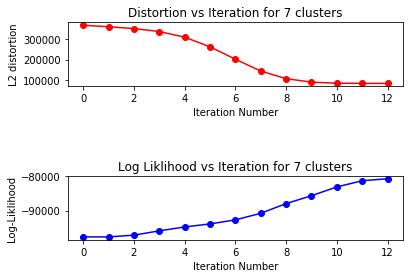

pi_s:	 [0.12410013 0.04420248 0.24215678 0.45453574 0.00802007 0.05339791
 0.07358687]
********** Invoked Expecation Maximization with 8 clusters **********
********** Expectation Maximization Completed! **********


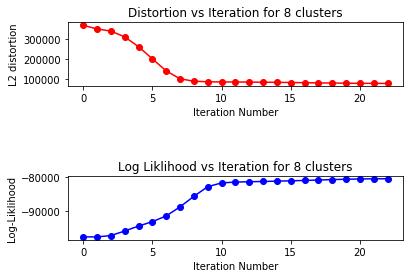

pi_s:	 [0.01793191 0.10083456 0.20053412 0.0005535  0.22007295 0.29828786
 0.03705331 0.1247318 ]


In [21]:
unknownK_state = show_best_cluster(unknown_data,LOW_LIM,HIGH_LIM)

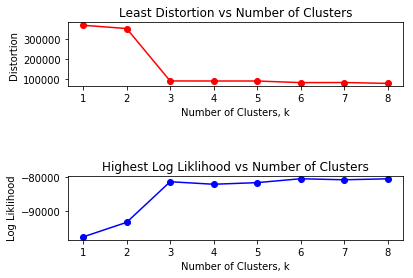

Ideal Cluster Number:  3
{'mu_s': array([[[-5.01224616,  0.2136649 , -1.85066294,  1.06272609,
         -1.62733271]],

       [[ 4.7830239 , -0.55596234, -0.37048709,  1.19731843,
          4.41082412]],

       [[-0.0756494 ,  0.85103089, -1.44739484, -1.50557947,
          2.09991338]]]), 'pi_s': array([0.30176412, 0.53027306, 0.16796281]), 'sigma_s': array([[[ 0.43643472,  0.15699632,  0.29563014,  0.07359391,
          0.08165207],
        [ 0.15699632,  0.66423491,  0.06892914, -0.36287297,
         -0.70243024],
        [ 0.29563014,  0.06892914,  1.66571179,  0.90234176,
         -0.43162522],
        [ 0.07359391, -0.36287297,  0.90234176,  2.63103138,
         -0.29102499],
        [ 0.08165207, -0.70243024, -0.43162522, -0.29102499,
          1.3422154 ]],

       [[ 1.88944485,  0.64884996,  0.12873719, -0.02846868,
          0.27475778],
        [ 0.64884996,  1.74146542, -0.71925899, -1.11820324,
         -0.13626919],
        [ 0.12873719, -0.71925899,  2.72052692,  1.64

In [29]:
ideal_cluster = plot_best_cluster(unknownK_state,LOW_LIM,HIGH_LIM)

In [31]:
print("Ideal Cluster:\t",ideal_cluster)

#. Uncomment to save weights
#savez_compressed('classification_part_b.npz', unknownK_state[ideal_cluster]["labels"])

Ideal Cluster:	 3


### Choosing # of Clusters = 3 

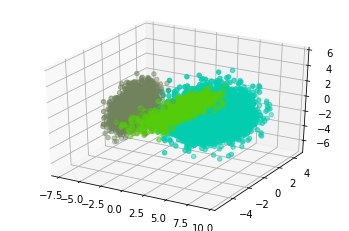

In [33]:
inline_plot(unknownK_state[ideal_cluster]["labels"],unknown_data)
# If you want to check the coloring for any particular number of clusters just change the index

## Verifying Part A as having 6 clusters

We can simply run the loop over the original data set and plot the distortion vs iterations (*scroll through below plots*)

********** Invoked Expecation Maximization with 1 clusters **********
********** Expectation Maximization Completed! **********


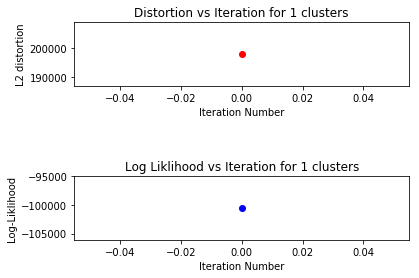

pi_s:	 [1.]
********** Invoked Expecation Maximization with 2 clusters **********
********** Expectation Maximization Completed! **********


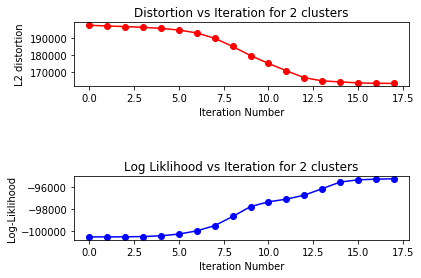

pi_s:	 [0.6057987 0.3942013]
********** Invoked Expecation Maximization with 3 clusters **********
********** Expectation Maximization Completed! **********


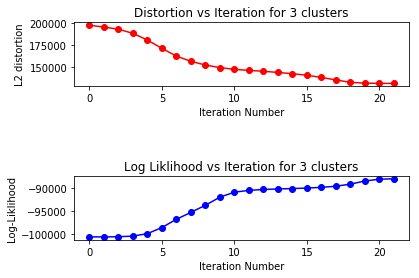

pi_s:	 [0.25163182 0.43152702 0.31684116]
********** Invoked Expecation Maximization with 4 clusters **********
********** Expectation Maximization Completed! **********


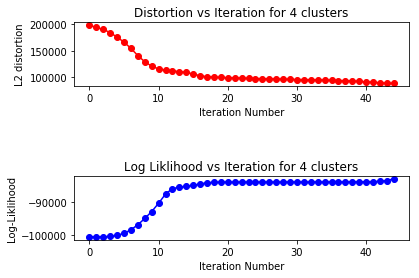

pi_s:	 [0.32380588 0.28034647 0.24787763 0.14797002]
********** Invoked Expecation Maximization with 5 clusters **********
********** Expectation Maximization Completed! **********


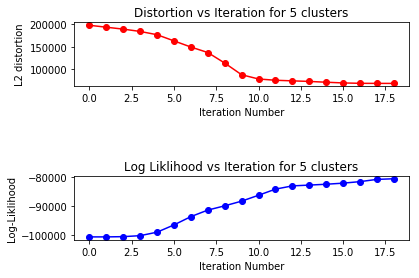

pi_s:	 [0.18338572 0.25658196 0.12844997 0.14786708 0.28371527]
********** Invoked Expecation Maximization with 6 clusters **********
********** Expectation Maximization Completed! **********


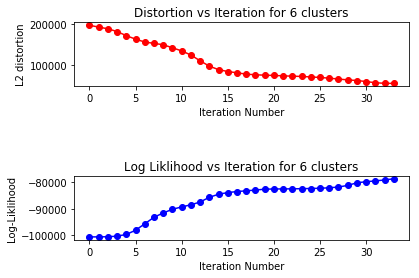

pi_s:	 [0.12698393 0.09828861 0.2821667  0.09560473 0.14795927 0.24899676]


In [34]:
part_a_state = show_best_cluster(test,LOW_LIM,HIGH_LIM-2)        

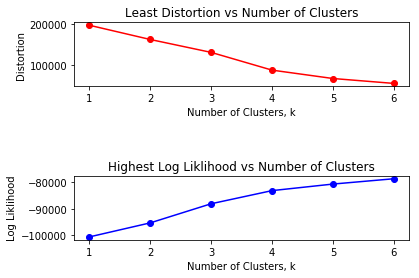

Ideal Cluster Number:  6
{'mu_s': array([[[-1.64819936, -2.04175713, -2.2578135 ,  0.16953   ,
          1.49391715]],

       [[-3.36027017, -3.37860806,  0.87847633, -2.00609166,
          1.76882938]],

       [[-2.25390451, -3.318678  ,  2.62363371,  2.32186288,
          1.96519757]],

       [[-1.88974292,  0.45165816,  3.83738374, -1.56548908,
          1.80824903]],

       [[-4.16830613,  1.05667775,  1.83387174, -0.27263422,
         -1.82738849]],

       [[ 0.64808551,  1.41699629,  1.73001373, -1.42315354,
          1.07129886]]]), 'pi_s': array([0.12698393, 0.09828861, 0.2821667 , 0.09560473, 0.14795927,
       0.24899676]), 'sigma_s': array([[[ 1.31338333e+00,  6.30411999e-01,  8.33637328e-02,
          1.64787735e-01,  2.41982497e-01],
        [ 6.30411999e-01,  1.45874087e+00,  1.33077429e-01,
         -6.55232176e-02, -4.94684405e-01],
        [ 8.33637328e-02,  1.33077429e-01,  1.48527006e+00,
          9.16347768e-01,  1.84266021e-01],
        [ 1.64787735e-01, -6.5

In [38]:
ideal_cluster_a = plot_best_cluster(part_a_state,LOW_LIM,HIGH_LIM-2)